In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utilities.transfrom import data_transform
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style("ticks")

In [2]:
# Import and transfrom the data in accordance to conslusions made in '1_Data'
df = pd.read_csv("./data/train.csv")
df_train = data_transform(df)

In [3]:
# Printing the heads
df_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22,7.2500,0,0,1,0,1,1
1,1,38,71.2833,0,0,0,0,0,0
2,1,26,7.9250,1,0,1,0,1,0
3,1,35,53.1000,0,0,0,0,1,0
4,0,35,8.0500,1,0,1,0,1,1


In [4]:
# Predictors
X = df_train[['Age', 'Fare', 'TravelAlone', 'Pclass_2', 'Pclass_3','Embarked_Q', 'Embarked_S', 'Sex_male']]

# Dependent variable
y = df_train["Survived"]

# Receiver Operating Characteristic

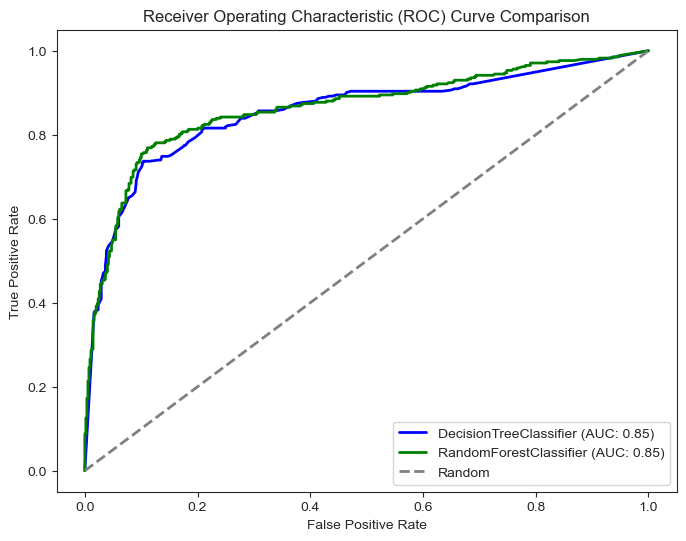

In [5]:
# Classifiers after optimization
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42)
rf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=40, random_state=42)

# Predictors after recursive feature elimination
X_dt = X[['Age', 'Fare', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Sex_male']]
X_rf = X[['Age', 'Fare', 'Pclass_3', 'Sex_male']]

# Cross-validator
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Cross-validated predictions for Decision Tree and Random Forest
y_prob_dt = cross_val_predict(dt, X_dt, y, cv=skf, method='predict_proba')[:,1]
y_prob_rf = cross_val_predict(rf, X_rf, y, cv=skf, method='predict_proba')[:,1]

# ROC curve for Decision Tree and Random Forest
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y, y_prob_dt)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, y_prob_rf)

# ROC AUC
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'{type(dt).__name__} (AUC: {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'{type(rf).__name__} (AUC: {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()

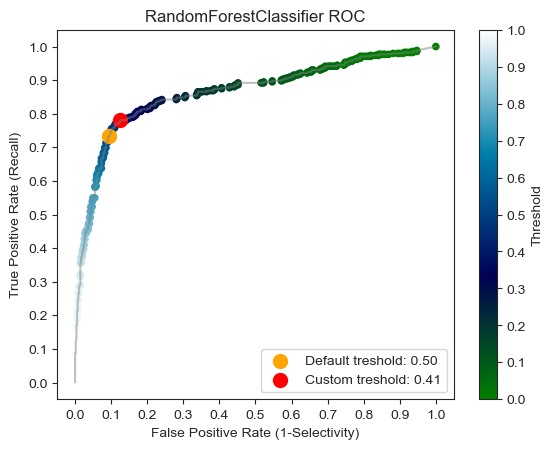

In [6]:
# Index of treshold closest to default 0.5
default_treshold_idx = np.absolute((thresholds_rf - 0.5)).argmin() # np.argmin() returns index of the minimal value
# Index of treshold closest to top left corner: (0,1)
euc_dist = np.sqrt((fpr_rf - 0) ** 2 + (tpr_rf - 1) ** 2) # euclidean distance between the curve point and (0,1)
custom_treshold_idx = euc_dist.argmin() # np.argmin() returns index of the minimal euclidean distance between the curve point and (0,1)

# Plot various tresholds
cplot = plt.scatter(fpr_rf, tpr_rf, c=thresholds_rf, cmap='ocean', s=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
cbar = plt.colorbar(cplot)
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_label('Threshold')

# Plot custom and default threshold
plt.scatter(fpr_rf[default_treshold_idx], tpr_rf[default_treshold_idx], color="orange", s=100, label=f"Default treshold: {thresholds_rf[default_treshold_idx]:.2f}")
plt.scatter(fpr_rf[custom_treshold_idx], tpr_rf[custom_treshold_idx], color="red", s=100, label=f"Custom treshold: {thresholds_rf[custom_treshold_idx]:.2f}")
plt.legend(loc='lower right')

plt.plot(fpr_rf, tpr_rf, linestyle='-', color='gray', alpha=0.5)
plt.xlabel('False Positive Rate (1-Selectivity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'{type(rf).__name__} ROC')
plt.show()

                                        Accuracy  Recall  Precission  F1 score
RandomForestClassifier(threshold=0.50)      0.84    0.73        0.83      0.78
RandomForestClassifier(threshold=0.41)      0.84    0.78        0.79      0.79


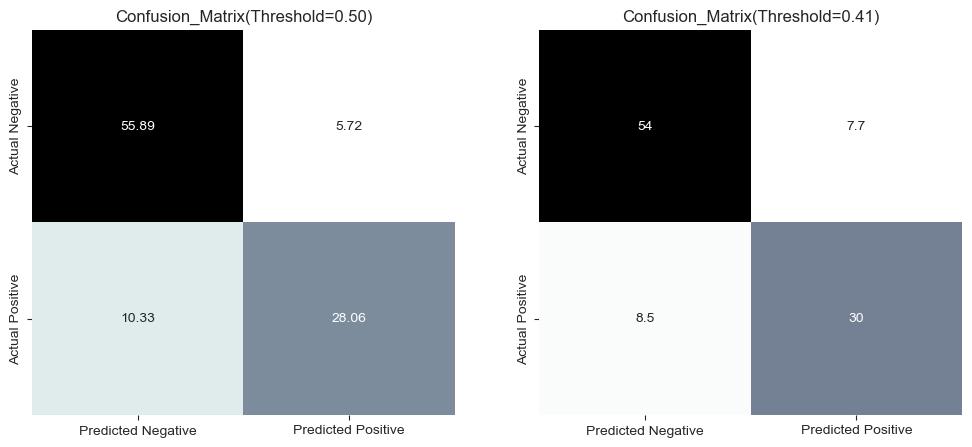

In [7]:
# Classifications for cross-validated predictions
y_pred_rf_default = np.where(y_prob_rf > thresholds_rf[default_treshold_idx], 1, 0)
y_pred_rf_custom = np.where(y_prob_rf > thresholds_rf[custom_treshold_idx], 1, 0)

# Data frame
scores = pd.DataFrame({
    "Accuracy": [accuracy_score(y, y_pred_rf_default), accuracy_score(y, y_pred_rf_custom)],
    "Recall": [recall_score(y, y_pred_rf_default), recall_score(y, y_pred_rf_custom)],
    "Precission": [precision_score(y, y_pred_rf_default), precision_score(y, y_pred_rf_custom)],
    "F1 score": [f1_score(y, y_pred_rf_default), f1_score(y, y_pred_rf_custom)]
    }, index=[f"{type(rf).__name__}(threshold={thresholds_rf[default_treshold_idx]:.2f})", 
              f"{type(rf).__name__}(threshold={thresholds_rf[custom_treshold_idx]:.2f})"]).round(2)

cm_default = (confusion_matrix(y, y_pred_rf_default, normalize="all") * 100).round(2) # Confusion matrix for Random Forest with default threshold=0.5
cm_custom = (confusion_matrix(y, y_pred_rf_custom, normalize="all")  * 100).round(2) # Confusion matrix for Random Forest with custom threshold

# Plotting confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Confusion matrix: default threshold
ax = axes[0]
sns.heatmap(cm_default, annot=True, fmt='g', cmap='bone_r', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=ax)
ax.set_title(f'Confusion_Matrix(Threshold={thresholds_rf[default_treshold_idx]:.2f})')

# Confusion matrix: custom threshold
ax = axes[1]
sns.heatmap(cm_custom, annot=True, cmap='bone_r', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], ax=ax)
ax.set_title(f'Confusion_Matrix(Threshold={thresholds_rf[custom_treshold_idx]:.2f})')

print(scores)
plt.show()

Here's a brief explanation of each metric:

- **Accuracy**: The proportion of correctly classified instances out of the total instances.
- **Precision**: The proportion of true positive predictions out of the total positive predictions. It indicates the accuracy of the positive predictions.
- **Recall (Sensitivity)**: The proportion of true positive predictions out of the actual positives. It measures the ability of the model to capture all the positive instances.
- **F1 Score**: The harmonic mean of precision and recall. It provides a balance between precision and recall.

In our case by lowering the threshold, the model became more sensitive, capturing a higher proportion of actual survivors. We increased sensitivity of the model, however in turn some of people which did not survive the disaster were classified as survivors as well. F1 Score (harmonic mean of precision and recall) indicates that amount of increased true positives to false positives speaks in favor of the model with the threshold adjusted.

Best accuracy (0.84) is achived for threshold: 0.47
Best F1 score (0.79) is achived for threshold: 0.45


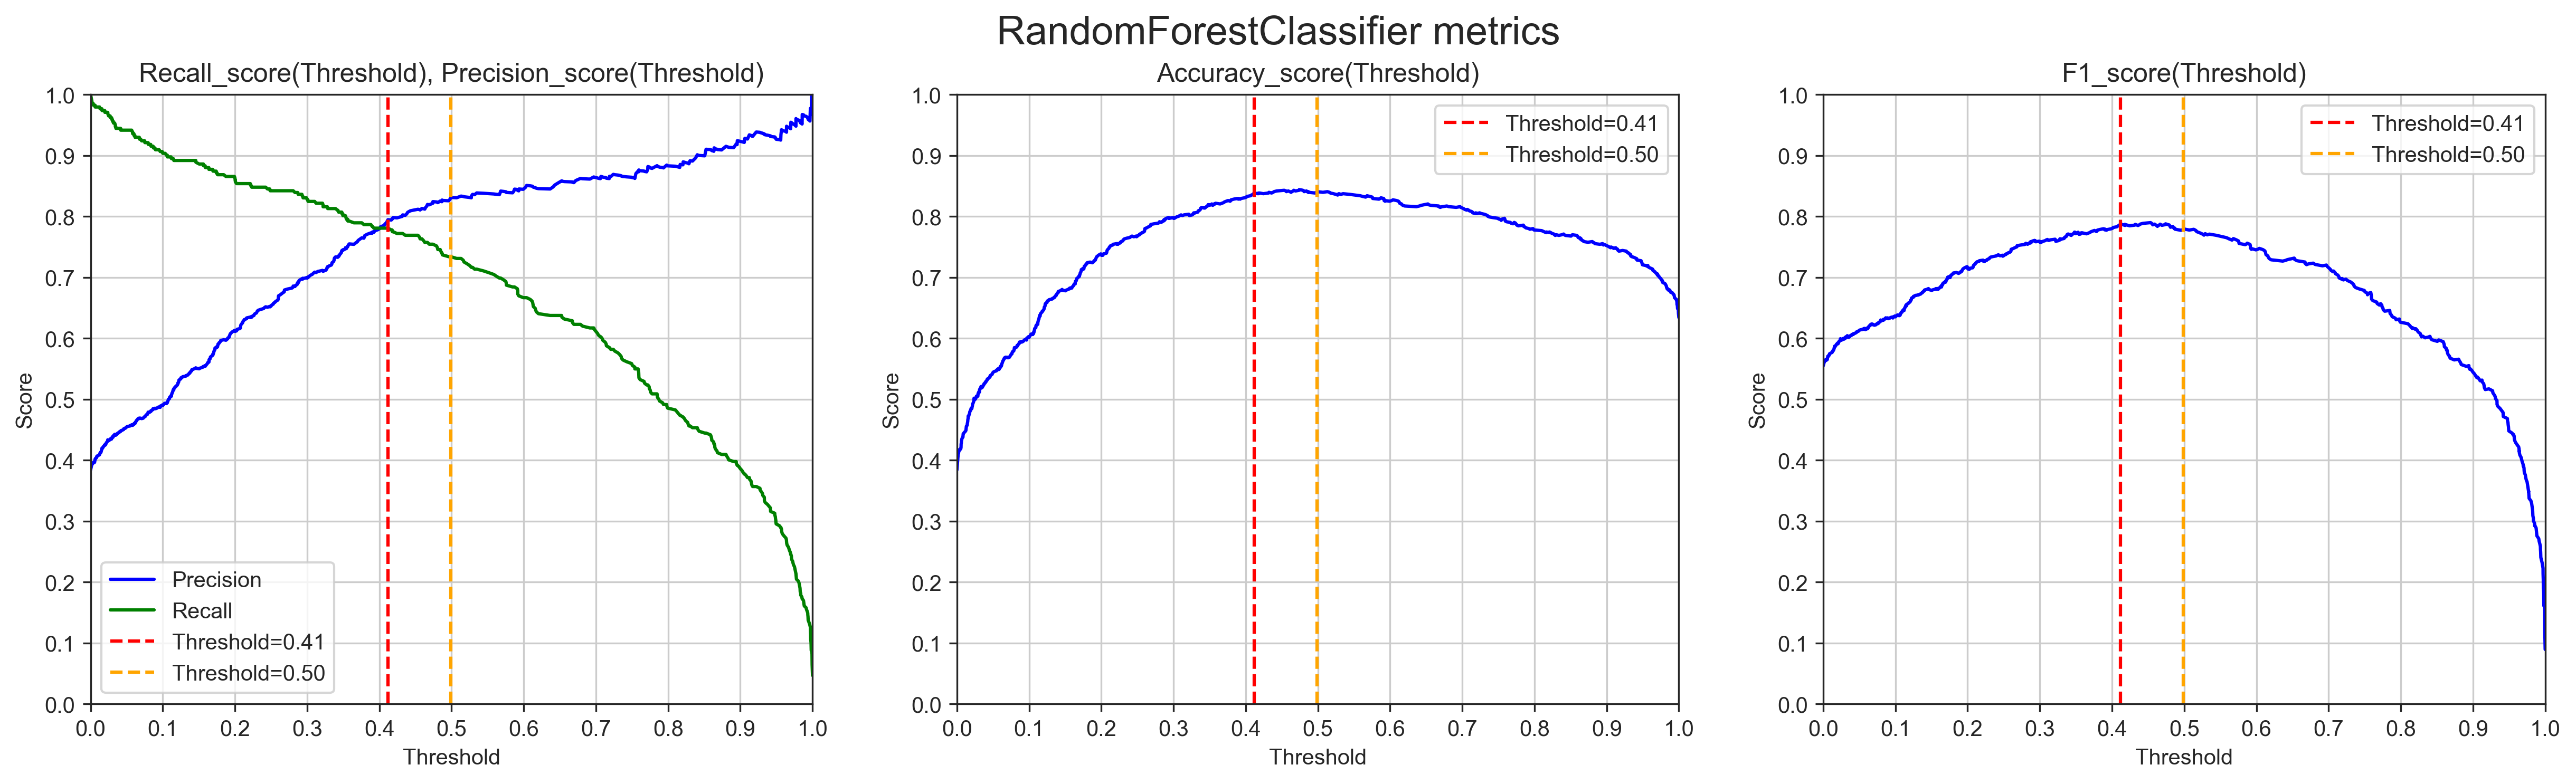

In [8]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_prob_rf)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=300)
fig.suptitle(f"{type(rf).__name__} metrics", size=18)

# Precision-Recall curves
ax = axes[0]
ax.set_title('Recall_score(Threshold), Precision_score(Threshold)')
ax.plot(thresholds, precision[:-1], label='Precision', color="blue")
ax.plot(thresholds, recall[:-1], label='Recall', color="green")

# Accuracy
acc = [accuracy_score(y, y_prob_rf >= threshold) for threshold in thresholds]
ax = axes[1]
ax.set_title('Accuracy_score(Threshold)')
ax.plot(thresholds, acc, color="blue")
ax.set_xlabel('Threshold')

# F1 score
f1 = [f1_score(y, y_prob_rf >= threshold) for threshold in thresholds]
ax = axes[2]
ax.set_title('F1_score(Threshold)')
ax.plot(thresholds, f1, color="blue")
ax.set_xlabel('Threshold')

for ax in axes:
    ax.axvline(x=thresholds_rf[custom_treshold_idx], linestyle='--', color='red', label=f'Threshold={thresholds_rf[custom_treshold_idx]:.2f}')
    ax.axvline(x=thresholds_rf[default_treshold_idx], linestyle='--', color='orange', label=f'Threshold={thresholds_rf[default_treshold_idx]:.2f}')
    ax.set_ylabel('Score')
    ax.set_xlabel('Threshold')
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid()

print(f"Best accuracy ({acc[np.array(acc).argmax()]:.2f}) is achived for threshold: {thresholds[np.array(acc).argmax()]:.2f}")
print(f"Best F1 score ({f1[np.array(f1).argmax()]:.2f}) is achived for threshold: {thresholds[np.array(f1).argmax()]:.2f}")

plt.show()

It happens that our custom threshold provided greater balance between recall and precission, therfore higher F1 score.

Please note that it is not always the case and it is a good practice to generate and analyze those plots.